In [1]:
# -*- coding: utf-8 -*-

# ライブラリインポート

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import time
import os
import csv
import collections
from collections import Counter
from tqdm import tqdm
import re
import itertools
import seaborn as sns

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.rc("font", **font)

In [4]:
from sklearn import cross_validation, preprocessing, decomposition #機械学習用のライブラリを利用
from sklearn.decomposition import PCA
from sklearn import metrics

/Users/kimiaki/virtualenv/py3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
import pickle

# データを読み込み

=> 623994件のデータが集まった。<br>
=> dataframe作成でのレコード数ミスがあったため修正（2017/12/24）

In [6]:
# df_all_fixの読み込み
df_all = pd.read_csv("../output/df_csv/df_all_fix.csv", encoding="utf-8")
print(df_all.shape)

# 不要列「Unnamed: 0」を削除
df_all = df_all.iloc[:, 1:]

# データ確認
print(df_all.shape)
df_all.head(3)

(207998, 36)
(207998, 35)


,レンタルタイプ,都道府県,市区町村,町域以下,立地1_路線,立地1_駅,立地1_バス,立地1_徒歩,立地2_路線,立地2_駅,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
0,賃貸アパート,東京,足立,西綾瀬４,東京メトロ千代田線,綾瀬駅,0,11,つくばエクスプレス,青井駅,...,0.0,0.0,2.0,0.0,1.0,0.0,0.0,24.00,26000.0,50000.0
1,賃貸アパート,東京,足立,小台２,日暮里・舎人ライナー,足立小台駅,0,17,ＪＲ高崎線,尾久駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.57,26000.0,52000.0
2,賃貸アパート,東京,足立,新田１,東京メトロ南北線,王子神谷駅,0,15,-,-,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,12.00,26500.0,50000.0


=> 207,998件のデータ。

# 予測モデル作成（１）
とりあえず、207,998件のデータを使って、次のモデルで予測モデルを作成してみる。<br>
- ①重回帰
- ②XGBoost
- ③DNN

## 使用データを選別

まず、予測に使う変数を、「予測のインプット変数」「変数の数」を考慮して考える。

In [7]:
df_all.iloc[1, :]

レンタルタイプ        賃貸アパート
都道府県               東京
市区町村               足立
町域以下              小台２
立地1_路線     日暮里・舎人ライナー
立地1_駅           足立小台駅
立地1_バス              0
立地1_徒歩             17
立地2_路線          ＪＲ高崎線
立地2_駅             尾久駅
立地2_バス              0
立地2_徒歩             27
立地3_路線     日暮里・舎人ライナー
立地3_駅            熊野前駅
立地3_バス              0
立地3_徒歩             21
利用路線数               3
築年数                48
地下                  0
地上                  2
階                   1
賃料              26000
管理費                 0
敷金              26000
礼金              26000
保証金                 0
敷引,償却費              0
部屋数                 1
D有無                 0
K有無                 0
L有無                 0
S有無                 0
専有面積            11.57
月額費用            26000
初期費用            52000
Name: 1, dtype: object

In [8]:
# 変数を選択
df_all_1 = df_all.loc[:, ["レンタルタイプ","都道府県","市区町村","立地1_路線","立地1_バス","立地1_徒歩","利用路線数","築年数","地下","地上","階","部屋数","D有無","K有無","L有無","S有無","専有面積"]]
print(df_all_1.shape)

(207998, 17)


次に、相関が高い変数を削除する

(207998, 13)
   立地1_バス  立地1_徒歩  利用路線数  築年数  地下  地上  階  部屋数  D有無  K有無  L有無  S有無   専有面積
0       0      11    3.0   33   0   2  2  2.0  0.0  1.0  0.0  0.0  24.00
1       0      17    3.0   48   0   2  1  1.0  0.0  0.0  0.0  0.0  11.57
2       0      15    3.0   43   0   2  1  1.0  0.0  1.0  0.0  0.0  12.00


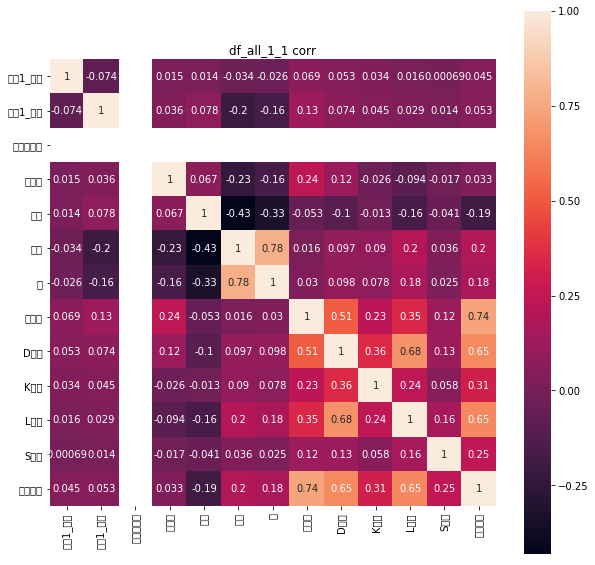

In [9]:
## 数値変数を相関から変数削減

# 数値変数を抽出
df_all_1_1 = df_all_1.loc[:, ["立地1_バス","立地1_徒歩","利用路線数","築年数","地下","地上","階","部屋数","D有無","K有無","L有無","S有無","専有面積"]]
print(df_all_1_1.shape)
print(df_all_1_1.head(3))

# 相関を確認
plt.figure(figsize=(10, 10))
plt.title('df_all_1_1 corr')
sns.heatmap(df_all_1_1.corr(), square=True, annot=True)

上図から、地上と階（0.78）、部屋数と専有面積（0.74）、D有無とL有無（0.68）、D有無と専有面積（0.65）、L有無と専有面積（0.65）、が高い相関となっている。<br>
専有面積は部屋数・D有無・L有無と相関が高いので除く、D有無とL有無では何となくD有無を除くこととする。

In [10]:
# データの除去
df_all_1 = df_all_1.drop(["D有無","専有面積"], axis=1)

## ダミー変数化

In [11]:
## ダミー変数作成
# データ結合用にインデックスをリセット
df_all_1 = df_all_1.reset_index(drop=True)
print(df_all_1.shape)
# ダミー変数作成
df_dummy = pd.get_dummies(df_all_1[["レンタルタイプ","都道府県","市区町村","立地1_路線"]], drop_first=True)
print(df_dummy.shape)
# データ結合
df_all_2 = pd.merge(df_all_1, df_dummy, left_index=True, right_index=True)
print(df_all_2.shape)
# 元変数を削除
df_all_2 = df_all_2.drop(["レンタルタイプ","都道府県","市区町村","立地1_路線"], axis=1)
print(df_all_2.shape)

(207998, 15)
(207998, 104)
(207998, 119)
(207998, 115)


## 次元圧縮(必要時)：PCA

PCAで次元圧縮する。<br>
Ref）http://neuro-educator.com/ml21/

## 予測モデルを作成

### ①重回帰

- Ref）https://pythondatascience.plavox.info/scikit-learn/%E7%B7%9A%E5%BD%A2%E5%9B%9E%E5%B8%B0

In [13]:
# ライブラリインポート
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

In [14]:
# X, Yを設定
X = df_all_2.as_matrix()
Y = df_all["月額費用"].as_matrix()

In [49]:
# 重回帰モデル作成：全データを学習
lm_all = linear_model.LinearRegression()
lm_all.fit(X, Y)

# RMSE
y_pred = lm_all.predict(X)
rmse = np.sqrt(np.sum(np.square(y_pred - Y))/len(y_pred))
print("RMSE: ", rmse)

# 偏回帰係数
print(pd.DataFrame({"Name": df_all_2.columns, "Coefficients": lm_all.coef_}).sort_values(by="Name"))
# 切片（誤差）
print(lm_all.intercept_)

# モデルを保存
#Ref）https://localab.jp/blog/save-and-load-machine-learning-models-in-python-with-scikit-learn/
filename_lm_all = "../output/model/model_lm_all.sav"
pickle.dump(lm_all, open(filename_lm_all, "wb"))

RMSE:  49361.7813314
     Coefficients                    Name
8    4.422130e+03                     K有無
9    4.865083e+04                     L有無
10   3.604811e+04                     S有無
11  -3.198962e+04          レンタルタイプ_賃貸アパート
12  -3.050829e+04    レンタルタイプ_賃貸テラス・タウンハウス
13  -2.984242e+04         レンタルタイプ_賃貸マンション
14  -1.394058e+04          レンタルタイプ_賃貸一戸建て
2    1.034785e-10                   利用路線数
5    8.296923e+02                      地上
4   -2.823229e+04                      地下
15  -9.833893e+03                 市区町村_中央
16  -1.268671e+04                 市区町村_中野
17  -1.327578e+04                  市区町村_北
18   2.518534e+04                市区町村_千代田
19  -2.503807e+04                 市区町村_台東
20   7.342279e+03                 市区町村_品川
21  -2.248641e+04                 市区町村_墨田
22  -3.756880e+03                 市区町村_大田
23  -3.059959e+03                 市区町村_文京
24  -1.289995e+03                 市区町村_新宿
25  -1.381448e+04                 市区町村_杉並
26  -2.449130e+04                 市区町村_板橋
27  -3.634895

実測値と予測値がどれぐらい当たっているか確認

In [96]:
sub_int = y_pred - Y
sub_rate = (y_pred - Y)/Y
id = list(range(1, len(sub_int) + 1))
names = ["Actual", "Predicted", "Error", "Error_rate"]
df_summary = pd.DataFrame({"Actual": Y, "Predicted": y_pred, "Error": sub_int, "Error_rate": sub_rate}, index=df_all_2.index).sort_values(by="Actual")

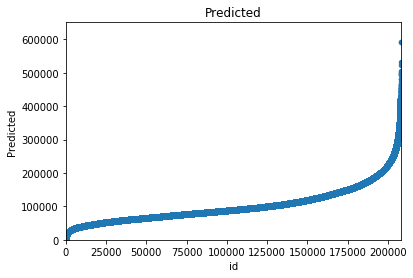

In [105]:
name = names[1]
df_ = df_summary.sort_values(by = name)
df_["id"] = id
#lim_max = int(max(max(df_summary["Actual"]), max(df_summary["Predicted"])) * 1.1)
y_max = int(max(df_[name]) * 1.1)
y_min = int(min(0, min(df_[name]) * 1.1))
#df_.plot(kind = "scatter",  x = "id", y = name, xlim = (0, len(id)+1), ylim = (y_min, y_max), title = name)
df_.plot(kind = "scatter",  x = "id", y = name, xlim = (0, len(id)+1), ylim = (0, y_max), title = name)

### ②XGBoost

### ③DNN

# データ異常値確認

* ref)https://pythondatascience.plavox.info/seaborn/%E6%A3%92%E3%82%B0%E3%83%A9%E3%83%95
* ref Seaborn)https://pythondatascience.plavox.info/seaborn/%E6%A3%92%E3%82%B0%E3%83%A9%E3%83%95
* ref pdPlot)https://qiita.com/hik0107/items/de5785f680096df93efa

In [5]:
df_all.describe()

,立地1_バス,立地1_徒歩,立地2_バス,立地2_徒歩,立地3_バス,立地3_徒歩,築年数,地下,地上,階,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
count,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,623994.000000,...,6.239940e+05,6.239940e+05,623994.000000,623994.000000,623994.000000,623994.000000,623994.00000,623994.000000,6.239940e+05,6.239940e+05
mean,0.097789,7.677107,0.237286,11.617040,0.288450,13.752022,18.944024,-0.072092,5.763055,3.364542,...,1.816764e+03,3.725696e+03,1.303964,0.364951,0.819912,0.208978,0.01513,32.426672,1.029661e+05,1.955473e+05
std,1.160823,4.624772,2.037352,6.333507,2.359231,8.145962,14.175776,0.335441,5.610024,3.408785,...,2.899270e+04,2.499557e+04,0.615314,0.481417,0.384261,0.406579,0.12207,19.462988,7.370993e+04,1.063760e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.000000,1.000000,-6.000000,...,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000,0.00000,0.100000,1.780000e+04,0.000000e+00
25%,0.000000,4.000000,0.000000,8.000000,0.000000,9.000000,7.000000,0.000000,2.000000,2.000000,...,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.00000,20.720000,6.900000e+04,7.400000e+04
50%,0.000000,7.000000,0.000000,11.000000,0.000000,14.000000,17.000000,0.000000,4.000000,2.000000,...,0.000000e+00,0.000000e+00,1.000000,0.000000,1.000000,0.000000,0.00000,26.000000,8.700000e+04,1.340000e+05
75%,0.000000,10.000000,0.000000,15.000000,0.000000,19.000000,29.000000,0.000000,7.000000,4.000000,...,0.000000e+00,0.000000e+00,1.000000,1.000000,1.000000,0.000000,0.00000,40.000000,1.150000e+05,2.000000e+05
max,35.000000,472.000000,50.000000,70.000000,65.000000,222.000000,99.000000,0.000000,60.000000,60.000000,...,5.138000e+06,2.800000e+06,10.000000,1.000000,1.000000,1.000000,1.00000,679.200000,3.500000e+06,4.850097e+09


=> バス65分、地上60階、10部屋、はなんとなくありそうだが、<br>
   徒歩472分、築年数99年、地下9階、専有面積679m2、初期費用48億円、は自分の感覚的になさそうなので、ミスデータか確認してみる。

## 徒歩：472分

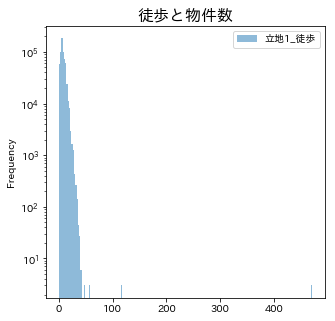

In [20]:
df_all.plot(y=["立地1_徒歩"], alpha=0.5, figsize=(5,5), kind="hist", bins=200, logy=True)
plt.title("徒歩と物件数", size=16)
plt.show()

=> 立地1_徒歩 100分未満で再確認

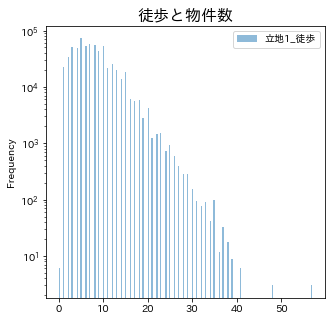

In [18]:
df_all[df_all["立地1_徒歩"] < 100].plot(y=["立地1_徒歩"], alpha=0.5, figsize=(5,5), kind="hist", bins=200, logy=True)
plt.title("徒歩と物件数", size=16)
plt.show()

=> 徒歩60分までとし、60分以上は今回は除外する。

## 築年数：99年

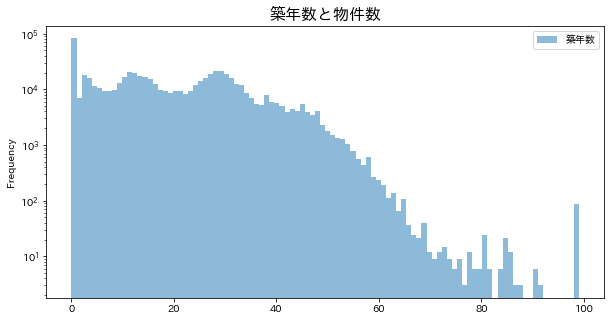

In [25]:
df_all.plot(y=["築年数"], alpha=0.5, figsize=(10,5), kind="hist", bins=100, logy=True)
plt.title("築年数と物件数", size=16)
plt.show()

=> 何となく築99年未満はデータ正しそうだけど、築99年は約100件あるため、データを確認。

In [15]:
df_all[df_all["築年数"] == 99]

,レンタルタイプ,都道府県,市区町村,町域以下,立地1_路線,立地1_駅,立地1_バス,立地1_徒歩,立地2_路線,立地2_駅,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
2501,賃貸アパート,東京,足立,東和５,東京メトロ千代田線,北綾瀬駅,0,11,ＪＲ常磐線,亀有駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.30,55000.0,0.0
2502,賃貸アパート,東京,足立,東和５,東京メトロ千代田線,北綾瀬駅,0,11,ＪＲ常磐線,亀有駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.30,55000.0,0.0
2503,賃貸アパート,東京,足立,東和５,東京メトロ千代田線,北綾瀬駅,0,11,ＪＲ常磐線,亀有駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.30,55000.0,0.0
3949,賃貸アパート,東京,足立,青井２,つくばエクスプレス,青井駅,0,9,東武伊勢崎線,五反野駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.30,60000.0,0.0
43768,賃貸アパート,東京,板橋,稲荷台,都営三田線,板橋本町駅,0,11,ＪＲ埼京線,十条駅,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,28.00,72000.0,144000.0
54396,賃貸アパート,東京,葛飾,高砂８,成田スカイアクセス,京成高砂駅,0,5,京成金町線,柴又駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.00,63000.0,0.0
54397,賃貸アパート,東京,葛飾,高砂８,成田スカイアクセス,京成高砂駅,0,5,京成金町線,柴又駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.00,63000.0,0.0
54398,賃貸アパート,東京,葛飾,高砂８,成田スカイアクセス,京成高砂駅,0,5,京成金町線,柴又駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.00,65000.0,0.0
54399,賃貸アパート,東京,葛飾,高砂８,成田スカイアクセス,京成高砂駅,0,5,京成金町線,柴又駅,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.00,65000.0,0.0
59593,賃貸アパート,東京,北,堀船１,ＪＲ京浜東北線,王子駅,0,9,東京メトロ南北線,王子駅,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,23.00,56000.0,168000.0


<img src="../picture/age99_1.png">
<img src="../picture/age99_2.png">
<img src="../picture/age99_3.png">

=> いくつか確認したが、新築っぽい感じで、おそらく入力ミス。ただし、100件だけどデータミスと判断し、分析データからは除外する。

## 地下：9階

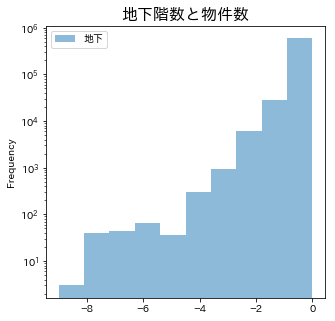

In [17]:
df_all.plot(y=["地下"], alpha=0.5, figsize=(5,5), kind="hist", bins=10, logy=True)
plt.title("地下階数と物件数", size=16)
plt.show()

=> B9Fは1件だが、〜B8Fも数十件ずつ存在。とりあえずデータ確認してみる。

In [28]:
df_all[df_all["地下"] == -9]

,レンタルタイプ,都道府県,市区町村,町域以下,立地1_路線,立地1_駅,立地1_バス,立地1_徒歩,立地2_路線,立地2_駅,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
207813,賃貸マンション,東京,豊島,雑司が谷１,東京メトロ有楽町線,護国寺駅,0,8,東京メトロ丸ノ内線,新大塚駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,57.04,185000.0,555000.0
415811,賃貸マンション,東京,豊島,雑司が谷１,東京メトロ有楽町線,護国寺駅,0,8,東京メトロ丸ノ内線,新大塚駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,57.04,185000.0,555000.0
623809,賃貸マンション,東京,豊島,雑司が谷１,東京メトロ有楽町線,護国寺駅,0,8,東京メトロ丸ノ内線,新大塚駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,57.04,185000.0,555000.0


<img src="../picture/B9F_1.png">
<img src="../picture/B9F_2.png">

=> これは入力ミスでした。おそらく9と0を打ち間違っている。<br>
=> 地下9は地下0に修正して対応する。

In [26]:
df_all[df_all["地下"] == -8]

,レンタルタイプ,都道府県,市区町村,町域以下,立地1_路線,立地1_駅,立地1_バス,立地1_徒歩,立地2_路線,立地2_駅,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
24472,賃貸マンション,東京,中央,日本橋茅場町２,東京メトロ東西線,茅場町駅,0,2,東京メトロ日比谷線,八丁堀駅,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,27.39,111000.0,206000.0
24473,賃貸マンション,東京,中央,日本橋茅場町２,東京メトロ東西線,茅場町駅,0,2,東京メトロ日比谷線,八丁堀駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,38.11,160000.0,375000.0
24474,賃貸マンション,東京,中央,日本橋茅場町２,東京メトロ東西線,茅場町駅,0,2,東京メトロ日比谷線,八丁堀駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,38.11,160000.0,375000.0
24475,賃貸マンション,東京,中央,日本橋茅場町２,東京メトロ東西線,茅場町駅,0,2,東京メトロ日比谷線,八丁堀駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,38.11,160000.0,375000.0
126260,賃貸マンション,東京,大田,大森北１,ＪＲ京浜東北線,大森駅,0,3,京急本線,大森海岸駅,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,36.49,129000.0,129000.0
172906,賃貸マンション,東京,新宿,新宿７,都営大江戸線,東新宿駅,0,3,ＪＲ山手線,新宿駅,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,38.71,145000.0,268000.0
173891,賃貸マンション,東京,新宿,富久町,都営新宿線,曙橋駅,0,6,東京メトロ丸ノ内線,四谷三丁目駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,57.65,200000.0,487500.0
173892,賃貸マンション,東京,新宿,富久町,都営新宿線,曙橋駅,0,6,東京メトロ丸ノ内線,四谷三丁目駅,...,0.0,0.0,2.0,1.0,1.0,1.0,0.0,57.65,204000.0,597000.0
193697,賃貸マンション,東京,墨田,東駒形１,都営浅草線,浅草駅,0,5,都営大江戸線,蔵前駅,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,25.20,92000.0,92000.0
193698,賃貸マンション,東京,墨田,東駒形１,都営浅草線,浅草駅,0,5,都営大江戸線,蔵前駅,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,26.76,96000.0,176000.0


物件データ取得から時間が空いたため、物件の掲載が終了していた。
<img src="../picture/suumo_notfound.png">

=> 結局地下に関してはよくわからないので、ここは割り切って地下物件はあってもほとんど誤差と考え、予測分析には列「地下」は使わないことにする。

## 専有面積：679m2

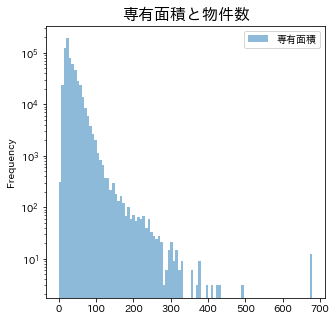

In [30]:
df_all.plot(y=["専有面積"], alpha=0.5, figsize=(5,5), kind="hist", bins=100, logy=True)
plt.title("専有面積と物件数", size=16)
plt.show()

=> 400m2以上ちょくちょくあるため、それぞれデータを確認。

In [39]:
df_all[df_all["専有面積"] > 400].sort_values(by="専有面積")

,レンタルタイプ,都道府県,市区町村,町域以下,立地1_路線,立地1_駅,立地1_バス,立地1_徒歩,立地2_路線,立地2_駅,...,保証金,"敷引,償却費",部屋数,D有無,K有無,L有無,S有無,専有面積,月額費用,初期費用
571706,賃貸一戸建て,東京,渋谷,千駄ヶ谷２,ＪＲ総武線,千駄ヶ谷駅,0,8,都営大江戸線,国立競技場駅,...,0.0,0.0,4.0,1.0,1.0,1.0,0.0,410.00,3500000.0,14000000.0
363708,賃貸一戸建て,東京,渋谷,千駄ヶ谷２,ＪＲ総武線,千駄ヶ谷駅,0,8,都営大江戸線,国立競技場駅,...,0.0,0.0,4.0,1.0,1.0,1.0,0.0,410.00,3500000.0,14000000.0
155710,賃貸一戸建て,東京,渋谷,千駄ヶ谷２,ＪＲ総武線,千駄ヶ谷駅,0,8,都営大江戸線,国立競技場駅,...,0.0,0.0,4.0,1.0,1.0,1.0,0.0,410.00,3500000.0,14000000.0
536779,賃貸マンション,東京,大田,西糀谷３,京急空港線,大鳥居駅,0,11,京急空港線,糀谷駅,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,423.71,83000.0,162000.0
328781,賃貸マンション,東京,大田,西糀谷３,京急空港線,大鳥居駅,0,11,京急空港線,糀谷駅,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,423.71,83000.0,162000.0
120783,賃貸マンション,東京,大田,西糀谷３,京急空港線,大鳥居駅,0,11,京急空港線,糀谷駅,...,0.0,0.0,2.0,1.0,1.0,0.0,0.0,423.71,83000.0,162000.0
447342,賃貸マンション,東京,江戸川,南葛西２,東京メトロ東西線,葛西駅,0,13,ＪＲ京葉線,葛西臨海公園駅,...,0.0,69000.0,2.0,1.0,1.0,0.0,0.0,429.00,69000.0,138000.0
239344,賃貸マンション,東京,江戸川,南葛西２,東京メトロ東西線,葛西駅,0,13,ＪＲ京葉線,葛西臨海公園駅,...,0.0,69000.0,2.0,1.0,1.0,0.0,0.0,429.00,69000.0,138000.0
31346,賃貸マンション,東京,江戸川,南葛西２,東京メトロ東西線,葛西駅,0,13,ＪＲ京葉線,葛西臨海公園駅,...,0.0,69000.0,2.0,1.0,1.0,0.0,0.0,429.00,69000.0,138000.0
543446,賃貸一戸建て,東京,大田,田園調布３,東急東横線,田園調布駅,0,6,東急大井町線,自由が丘駅,...,0.0,0.0,9.0,1.0,1.0,1.0,1.0,492.84,1600000.0,4800000.0


674.13m2（7SLDK）：ページなかったが住所調べると、大使館？！とりあえずありえそう。
<img src="../picture/area674.png">

492.84m2（9SLDK）：実在していた！
<img src="../picture/area492_1.png">
<img src="../picture/area492_2.png">

=> 基本的に実在していたっぽい、という理解をするが、１件「423.71m2	月額費用83000.0	初期費用162000.0」はミスじゃないかな？と。<br>
他にも同様のものがないか、専有面積と家賃の分布を見てみる。

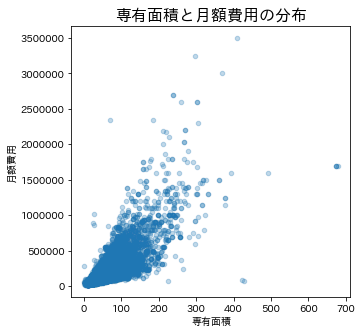

In [41]:
df_all.plot.scatter(x="専有面積", y="月額費用", alpha=0.1, figsize=(5,5))
plt.title("専有面積と月額費用の分布", size=16)
plt.show()

=>「400m2以上で月額費用が20万以下」「200m以上で月額費用20万以下」「100m2以下で月額費用200万以上」があるため、それぞれ確認してみる。

## 初期費用：48億円

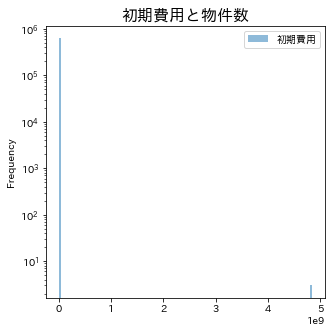

In [31]:
df_all.plot(y=["初期費用"], alpha=0.5, figsize=(5,5), kind="hist", bins=100, logy=True)
plt.title("初期費用と物件数", size=16)
plt.show()

# データの傾向を確認

★基本は統計量などを可視化などで把握していく。

以下を確認する。<br>
①23区ごとの物件数<br>
②徒歩と物件数<br>
③レンタルタイプごとの物件数<br>
④23区ごとの徒歩分布<br>
⑤23区ごとの築年数分布<br>
⑥徒歩と月額費用の分布<br>
⑦専有面積と月額費用の分布<br>
⑧路線数と月額費用の分布

## ①23区ごとの物件数

## ②徒歩と物件数

In [21]:
ax = df_all.plot(y=["立地1_徒歩"], alpha=0.5, figsize=(5,5), kind="hist", bins=)
plt.title("徒歩と物件数", size=16)
plt.show()

SyntaxError: invalid syntax (<ipython-input-21-255a1ceaccba>, line 1)

## ③レンタルタイプごとの物件数

## ④23区ごとの徒歩分布

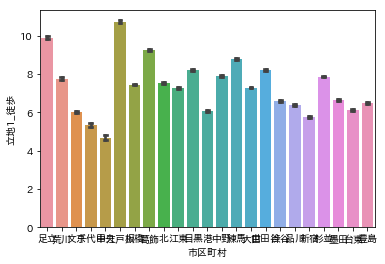

In [40]:
sns.barplot(x="市区町村", y="立地1_徒歩", data=df_all, capsize=.2)
plt.show()

## ⑤23区ごとの築年数分布

## ⑥徒歩と月額費用の分布

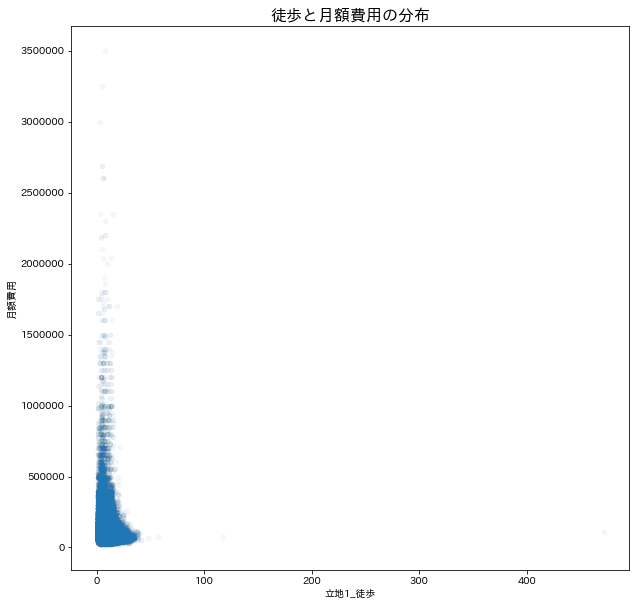

In [13]:
df_all.plot.scatter(x="立地1_徒歩", y="月額費用", alpha=0.01, figsize=(10,10))
plt.title("徒歩と月額費用の分布", size=16)
plt.show()

## ⑦専有面積と月額費用の分布

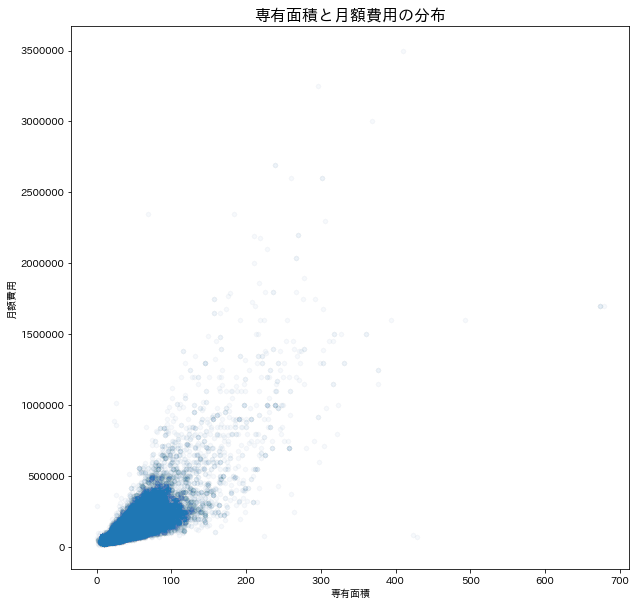

In [12]:
df_all.plot.scatter(x="専有面積", y="月額費用", alpha=0.01, figsize=(10, 10))
plt.title("専有面積と月額費用の分布", size=16)
plt.show()

# 予測モデル作成（２）

（１）と同様に、次のモデルを作成する。<br>
- ①ロジスティック回帰
- ②XGBoost
- ③DNN

# お買い物物件を探す